In [2]:
import requests
from bs4 import BeautifulSoup
import time
import re

In [3]:
def parse_object_page(url, object_n, object_list, base_url):
    """
    Fonction pour parser une page contenant des informations sur un type d'objet.
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Safari/537.3'}
    
    response = requests.get(url, headers=headers)

    if response.status_code == 200 :
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.find('table', class_='ak-table ak-responsivetable')
        if table:
            for row in table.find_all("tr")[1:]:
                recipe = []
                caracteristics = []
                effects = []
                time.sleep(1)
                
                name_element = row.find("td").find("a")
                name = name_element.text.strip()
                href = name_element['href']

                if object_n in ["equipements", "armes", "consommables"] :

                    recipe_url = base_url + href
                    recipe_response = requests.get(recipe_url, headers=headers)
                    while recipe_response.status_code != 200 and recipe_response.status_code != 404 : # bloqued script
                        time.sleep(10)
                        recipe_response = requests.get(recipe_url, headers=headers)

                    recipe_soup = BeautifulSoup(recipe_response.text, "html.parser")
                    recipe_elements = recipe_soup.find_all(class_='ak-column ak-container col-xs-12 col-sm-6')

                    # Recipe elements
                    for element in recipe_elements:
                        span_elements = element.find_all('span', class_='ak-linker')
                        for span in span_elements:
                            text = span.text.strip()
                            if text != '':
                                recipe.append(text)
                    
                    # Properties elements
                    if object_n in ["equipements", "armes"] :
                        ak_contents  = recipe_soup.find_all("div", class_="col-sm-6")
                        for ak_content in ak_contents:
                            panel_titles = ak_content.find_all(class_="ak-panel-title")

                            if any("Caractéristiques" in panel_title.text for panel_title in panel_titles):
                                ak_titles = ak_content.find_all("div", class_="ak-title")
                                if ak_titles:
                                    for ak_title in ak_titles:
                                        text = ak_title.get_text(strip=True)
                                        caracteristics.append(text)
                            
                            if any("Effets" in panel_title.text for panel_title in panel_titles):
                                ak_titles = ak_content.find_all("div", class_="ak-title")
                                if ak_titles:
                                    for ak_title in ak_titles:
                                        text = ak_title.get_text(strip=True)
                                        effects.append(text)
                            
                            if any("Conditions" in panel_title.text for panel_title in panel_titles):
                                break

                name = row.find("td").find("img")['alt'].strip()
                type_ = row.find("td", class_="item-type").text.strip()
                level_str = row.find("td", class_="item-level").text.strip()
                level = int(re.search(r'\d+', level_str).group())

                object_info = {
                    "name": name,
                    "type": type_,
                    "level": level
                }

                if object_n in ["equipements", "armes", "consommables"] :
                    object_info["recipe"] = recipe
                    if object_n in ["equipements", "armes"] :
                        object_info["caracteristic"] = caracteristics
                        object_info["effect"] = effects

                object_list.append(object_info)
            return True  # Indique que la page a été analysée avec succès
    else:
        return False  # Indique qu'il y a eu une erreur lors de la requête

In [6]:
def counter_page(url, object_name) :
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Safari/537.3'}
    
    response = requests.get(url, headers=headers)

    while response.status_code != 200 :
        time.sleep(10)
        response = requests.get(url, headers=headers)

    # Parse the HTML
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all <a> tags with href containing '/fr/mmorpg/encyclopedie/armes?page='
    url_object = f"/fr/mmorpg/encyclopedie/{object_name}\?page=\d+"
    links = soup.find_all('a', href=re.compile(url_object))

    # Extract numbers from the links
    numbers = [link.text.strip() for link in links if link.text.strip().isdigit()]
    last_pages = int(numbers[-1])
    return last_pages

In [7]:
def url_parser(base_url) :
    encyclopedia_url = base_url + "/fr/mmorpg/encyclopedie"

    objects = {
        "armes": [],
        "equipements": [],
        "consommables": [],
        "ressources": []
    }

    for object_name, object_list in objects.items():
        time.sleep(2)
        url = f"{encyclopedia_url}/{object_name}?page="
        nb_page = counter_page(url, object_name)
        for page in range(1, nb_page) :
            page_url = f"{url}{page}"
            success = parse_object_page(page_url, object_name, object_list, base_url)
            while success == False :
                time.sleep(10)
                success = parse_object_page(page_url, object_name, object_list, base_url)
        print(f"{len(object_list)} {object_name} find")
    
    return objects

In [8]:
base_url = "https://www.dofus-touch.com"
objects_touch = url_parser(base_url)

720 armes find
2040 equipements find
1248 consommables find
1824 ressources find


In [ ]:
base_url = "https://www.dofus.com"
objects_pc = url_parser(base_url)

In [11]:
import csv 

def save_object_list_to_csv(object_list, filename):
    """
    Create and save the object_list to a CSV file.
    """
    # Define the fieldnames based on the keys in the dictionaries in object_list
    fieldnames = object_list[0].keys()

    # Write object_list to a CSV file
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for obj in object_list:
            writer.writerow(obj)

def save_objects(objects) :
    # Assuming object_list is a dictionary where keys are object types and values are lists of objects
    for object_name, object_list in objects.items():

        filename = f"touch_{object_name}.csv"
        # Save the object list to the CSV file
        save_object_list_to_csv(object_list, filename)

In [ ]:
#save_objects(objects_touch)
save_objects(objects_pc)

In [46]:
import csv
import ast

def read_csv_file(filename, object_list):
    with open(filename, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)  # Using DictReader to directly read rows into dictionaries
        for row in reader:
            dict_item = {}
            for key, value in row.items():

                if isinstance(value, str):  # Check if the value is a string
                    dict_item[key] = value.replace("'", " ")
                elif isinstance(value, list):  # Check if the value is a list
                    dict_item[key] = [element.replace("'", " ") for element in value]
            
            try :
                dict_item['recipe'] = ast.literal_eval(row['recipe'])
            except :
                pass
            
            object_list.append(dict_item)
    return object_list

In [47]:
objects_touch = {
    "armes": [],
    "equipements": [],
    "consommables": [],
    "ressources": []
}

for object_name, object_list in objects_touch.items():
    object_list = read_csv_file(f"data/touch_{object_name}.csv", object_list)

In [72]:
objects_pc = {
    "armes": [],
    "equipements": [],
    "consommables": [],
    "ressources": []
}

for object_name, object_list in objects_pc.items():
    object_list = read_csv_file(f"data/pc_{object_name}.csv", object_list)

In [50]:
print(objects_touch["armes"][0:5])

[{'name': 'Hache Ériphe', 'type': 'Hache', 'level': '200', 'recipe': ['Galet acajou', 'Etoffe de Cuirassé', 'Bec de Strigide', 'Œil de verre', 'Essence de Glourséleste', "Graisse d'Archillusion", 'Écharpe de Hanshi', "Bracelet d'Ino-Naru"], 'caracteristic': '[ PA :5 (1 utilisation par tour) ,  Portée :1 ,  CC :15% (+8) ,  Force > 349 etAgilité de base > 349 ]', 'effect': '[ 15 à 19 (dommages Neutre) ,  21 à 27 (dommages Air) ,  8 à 11 (vol Terre) ,  201 à 250 Vitalité ,  41 à 60 Force ,  41 à 60 Agilité ,  4 à 5% Coups Critiques ,  1 PO ,  -301 à 400 Initiative ,  11 à 15 Prospection ,  14 à 18 Dommages Neutre ,  14 à 18 Dommages Terre ,  14 à 18 Dommages Air ,  7 à 10 % Résistance Neutre ,  7 à 10 % Résistance Air ,  7 à 10 Fuite ,  16 à 20 Dommages Poussée ]'}, {'name': 'Sceptre du Shushuverain', 'type': 'Baguette', 'level': '200', 'recipe': ['Etoffe de Kolosso', 'Galet brasillant', "Sang d'Armutin", "Poil d'aisselle de Missiz Frizz", 'Culotte de Missiz Frizz', 'Tourmaline', 'Orbe ir

In [87]:
import matplotlib.pyplot as plt

def calculate_occurrences(lst):
    occurrences = {}
    total_frequency = len(lst)
    level_occurence = []
    
    for n in range(len(lst)) :
        level_occurence.append(lst[n]["level"])

    for item in level_occurence:
        occurrences[int(item)] = occurrences.get(int(item), 0) + 1 / total_frequency
    
    occurrences = dict(sorted(occurrences.items()))
    return occurrences

def plot_occurrence_difference(occurrences1, occurrences2):
    differences = {}
    all_keys = set(occurrences1.keys()).union(occurrences2.keys())
    for key in all_keys:
        difference = (occurrences1.get(key, 0) - occurrences2.get(key, 0)) * 100
        differences[key] = difference
    
    # Plotting
    plt.figure(figsize=(16, 10))  # Augmenter la taille de la figure
    plt.bar(differences.keys(), differences.values())
    plt.xlabel('Niveaux')
    plt.ylabel('Fréquences (%)')
    plt.title('Fréquence des différence des occurrences divisé par leur ratio respectif en fonction du niveaux pour les armes entre dofus touch et dofus pc')
    plt.xticks(rotation=45)
    plt.show()

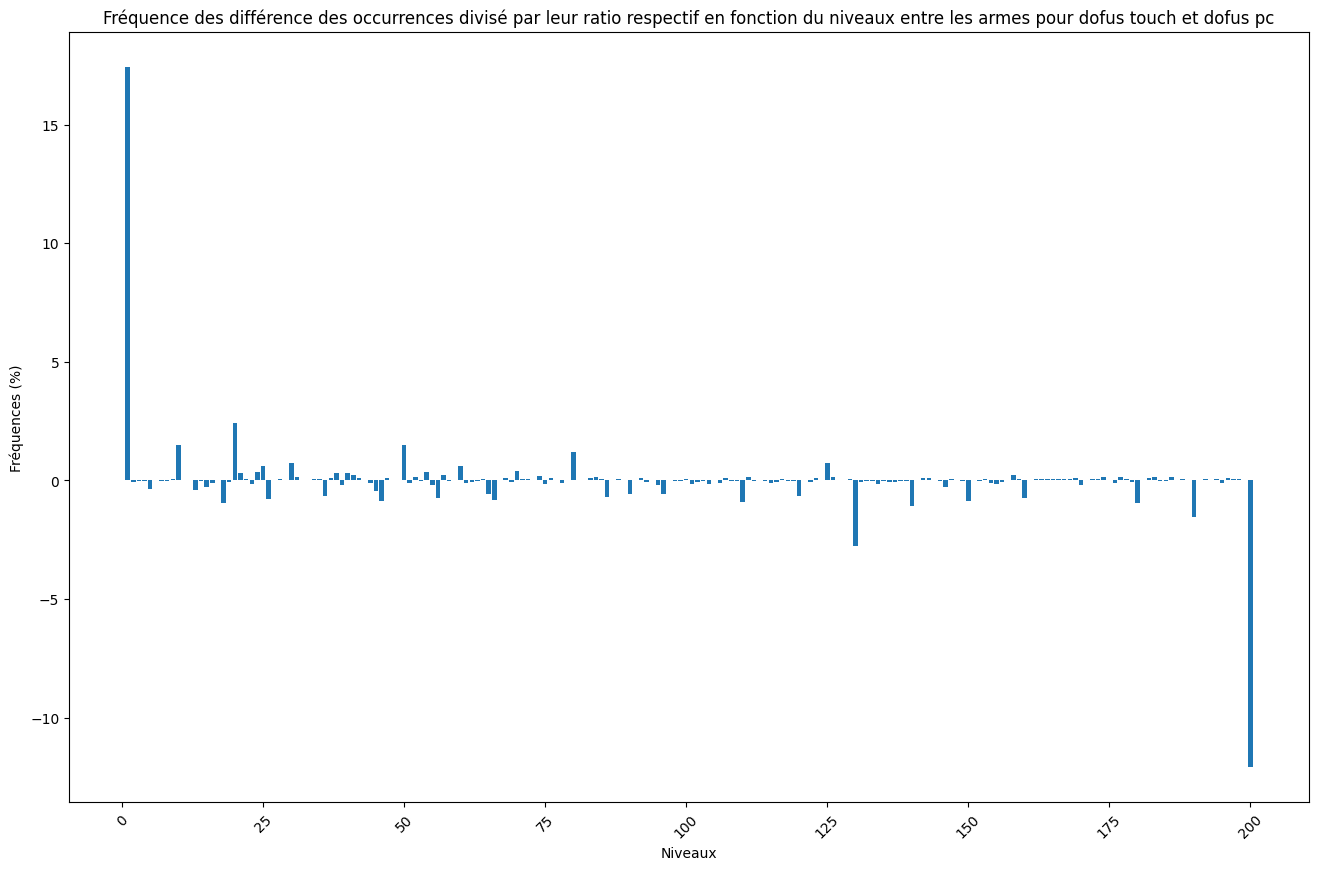

In [88]:
occurrences1 = calculate_occurrences(objects_touch["ressources"])
occurrences2 = calculate_occurrences(objects_pc["ressources"])
plot_occurrence_difference(occurrences1, occurrences2)

In [52]:
from collections import defaultdict

def create_dic_lvl_by_type(str_item):

    # List of characteristics to check for
    characteristics = ["Force", "Agilité", "Chance", "Intelligence", "Puissance"]

    # Initialize dictionary to store frequency of characteristics by level
    frequency_by_level = defaultdict(lambda: defaultdict(int))

    # Iterate over input data
    for item in objects_touch[str_item]:
        level = item['level']
        effect = item['effect']
        for characteristic in characteristics:
            if characteristic in effect:
                frequency_by_level[level][characteristic] += 1

    return characteristics, dict(frequency_by_level)

In [53]:
str_item = "armes"
characteristics, frequency_by_level = create_dic_lvl_by_type(str_item)

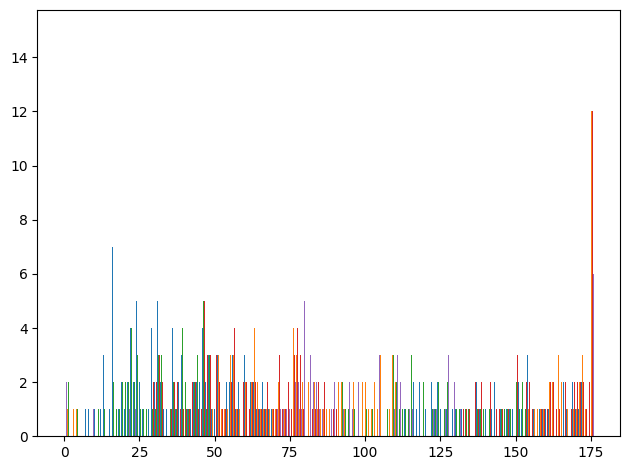

In [16]:
import matplotlib.pyplot as plt

# Order the dictionary by level
ordered_frequency_by_level = dict(sorted(frequency_by_level.items(), key=lambda x: int(x[0])))

# Extract data for plotting
levels = list(ordered_frequency_by_level.keys())
characteristics = list(characteristics)

# Check if there are any characteristics present
if any(any(characteristic in ordered_frequency_by_level[level] for characteristic in characteristics) for level in levels):

    # Create a plot for each characteristic
    bar_width = 0.2  # Adjust this value to change the width of each bar
    for i, characteristic in enumerate(characteristics):
        frequencies = [ordered_frequency_by_level[level].get(characteristic, 0) for level in levels]
        plt.bar([level + i * bar_width for level in range(len(levels))], frequencies, label=characteristic, width=bar_width)

    # # Add labels and title
    # plt.figure(figsize=(16, 10))  # Adjust the figsize as needed (width, height)
    # plt.xlabel('Level')
    # plt.ylabel('Frequency')
    # plt.title('Frequency of Characteristics by Level')

    # # Adjust x-axis ticks and labels
    # plt.xticks([level + bar_width * (len(characteristics) - 1) / 2 for level in range(len(levels))], levels)

    # # Show the legend
    # plt.legend()

    # # Show the plot
    plt.tight_layout()
    plt.show()

else:
    print("No characteristics found in the data.")